# Méthode du "Pairs Trading"

Le "Paris Trading" est un bon exemple de trading basé sur l'analyse mathématique. 

Le principe est le suivant :
Disons que nous avons une paire d'actions X et Y qui ont sont économiquent liées d'une manière sous-jacente. Il peut s'agir, par exemple, de deux sociétés qui fabriquent le même produit, comme McDonalds et Burger King. On s'attend donc à ce que l'écart (ratio ou différence de prix) entre ces deux actions reste constant dans le temps. Cependant, de temps en temps, il peut y avoir une divergence dans l'écart entre ces deux actions. La divergence au sein d'une paire peut être causée par des changements temporaires de l'offre et de la demande, des ordres d'achat et de vente importants pour un titre, la réaction à des nouvelles importantes concernant une des sociétés, etc. Lorsqu'il y a une divergence temporaire entre les deux titres, c'est-à-dire qu'une action monte alors que l'autre descend, le trading de paires consiste à vendre à découvert l'action qui surperforme et à acheter l'action qui sous-performe, en pariant que l'écart entre les deux finira par converger.

Le trading de paires est une stratégie de trading neutre par rapport au marché, qui permet aux traders de profiter de pratiquement toutes les conditions de marché : tendance à la hausse, tendance à la baisse ou mouvement latéral.

Nous allons commencer par utiliser un exemple construit sur la base de données générées synthétiquement.

In [12]:
!pip install backtester
!pip install statsmodels
!pip install tensorboardX
!pip install plotly
!pip install bs4
!pip install plotly
!pip install auquan_toolbox

  Using cached backtester-0.7-py3-none-any.whl (12 kB)
  Using cached mlxtend-0.18.0-py2.py3-none-any.whl (1.3 MB)
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached empiricaldist-0.6.1.tar.gz (9.4 kB)
  Created wheel for empiricaldist: filename=empiricaldist-0.6.1-py3-none-any.whl size=10628 sha256=04ffa18fca8e549a5fdbed4a20044a58cc36e655004764bfc21671512cba2095
  Stored in directory: /root/.cache/pip/wheels/de/e7/20/5d950acd2b8bb3a1f07f8a681652437a32a079f0b919709979
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=48f47fa4216144076d2b47d2a87428746b81a8f581faa3f843d6240f89074b97
  Stored in directory: /root/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built empiricaldist sklearn
  Using cached tensorboardX-2.2-py2.py3-none-any.whl (120 kB)
  Using cached bs4-0.0.1.tar.gz (1.1 kB)
  Using cached beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Using cached soupsieve-2.2.1-py3-none-any.whl (33 kB

In [1]:
import numpy as np
import pandas as pd
!pip install statsmodels
import statsmodels
from statsmodels.tsa.stattools import coint
# set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

  Using cached statsmodels-0.12.2-cp38-cp38-manylinux1_x86_64.whl (9.4 MB)
  Using cached patsy-0.5.1-py2.py3-none-any.whl (231 kB)


### Explication du "Pairs Trading" : Nous commençons par générer deux cours d'actions de manière synthétique.
Nous modélisons les rendements quotidiens de X en les tirant d'une distribution normale. Puis nous effectuons une somme cumulative pour obtenir la valeur de X chaque jour.

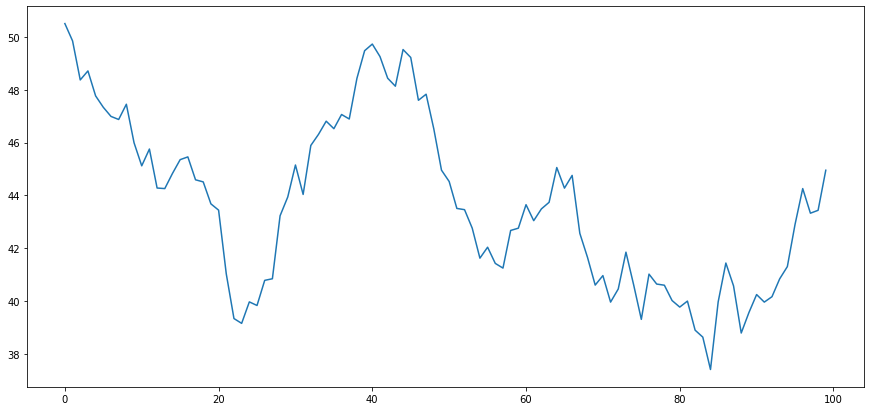

In [2]:
# Generate the daily returns
Xreturns = np.random.normal(0, 1, 100) 
# sum them and shift all the prices up
X = pd.Series(np.cumsum(Xreturns), name='X') + 50
X.plot(figsize=(15,7))
plt.show()

Nous générons maintenant Y. Y est censé avoir un lien économique profond avec X, de sorte que le prix de Y devrait varier de manière assez similaire. Nous modélisons cela en prenant X, en le décalant vers le haut et en ajoutant un bruit aléatoire tiré d'une distribution normale.

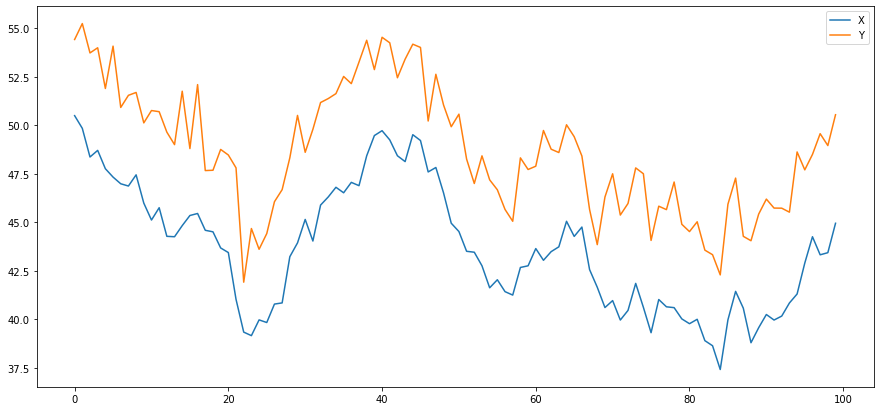

In [3]:
noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot(figsize=(15,7))
plt.show()

### La cointégration
La cointégration, au sens très large, est une forme "différente" de corrélation. Si deux séries sont cointégrées, le rapport entre elles variera autour d'une moyenne.
Pour que le "Pairs Trading" fonctionne entre deux séries chronologiques, la valeur attendue du ratio dans le temps doit converger vers la moyenne, c'est-à-dire qu'elles doivent être cointégrées.
Les séries chronologiques que nous avons construites ci-dessus sont cointégrées. 



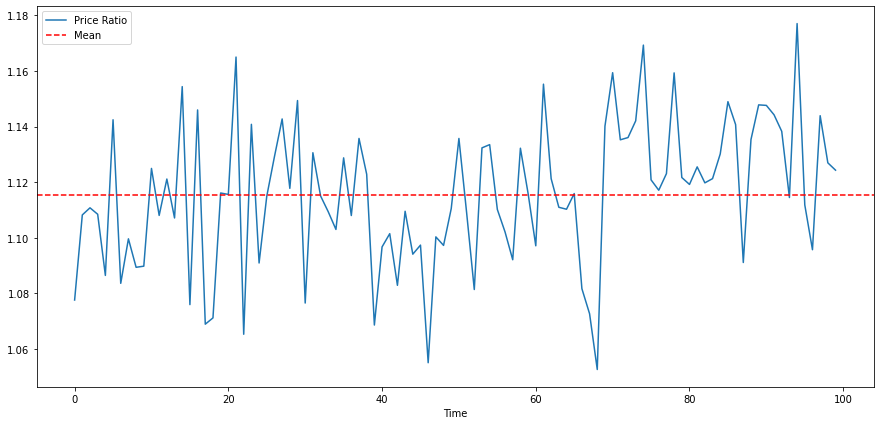

In [4]:
(Y/X).plot(figsize=(15,7)) 
plt.axhline((Y/X).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

### Test de cointégration
Il existe un test pratique qui se trouve dans statsmodels. Nous devrions voir apparaître une p-value très faible, car nous avons créé artificiellement deux séries qui sont aussi cointégrées que possible physiquement.

In [5]:
# compute the p-value of the cointegration test
# will inform us as to whether the ratio between the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)



### Comment faire du "Paris Trading"
Parce que deux séries temporelles cointégrées (comme X et Y ci-dessus) se rapprochent et s'éloignent l'une de l'autre, il y aura des moments où l'écart sera élevé et d'autres où il sera faible. Nous réalisons une opération en paire en achetant un titre et en en vendant un autre. De cette façon, si les deux titres baissent ou montent ensemble, nous ne gagnons ni ne perdons d'argent - nous sommes neutres par rapport au marché.

Pour en revenir à X et Y ci-dessus qui suivent Y = ⍺ X + e, de sorte que le ratio (Y/X) évolue autour de sa valeur moyenne ⍺, nous gagnons de l'argent sur le ratio des deux qui revient à la moyenne. Pour ce faire, nous surveillerons les moments où X et Y sont très éloignés, c'est-à-dire que ⍺ est trop élevé ou trop bas :

* Être long sur le ratio, c'est lorsque le ratio ⍺ est plus petit que d'habitude et que nous nous attendons à ce qu'il augmente. Dans l'exemple ci-dessus, nous faisons un pari sur ce ratio en achetant Y et en vendant X.
* C'est le cas lorsque le ratio ⍺ est élevé et que nous nous attendons à ce qu'il diminue. Dans l'exemple ci-dessus, nous parions sur cette situation en vendant Y et en achetant X.


### Utiliser les données historiques pour trouver des actions qui se comportent de cette manière
Nous commençons donc par trouver des actions ou titres que nous identifions comme potentiellement cointégrés, puis nous vérifions cela grâce à un test statistique avec une p-value.


Travaillons avec un ensemble de valeurs d'entreprises technologiques américaines à grande capitalisation dans l'indice boursier du S&P 500. Ces valeurs opèrent dans un segment similaire et pourraient avoir des prix cointégrés. Nous parcourons une liste de titres et testons la cointégration entre toutes les paires de titres. Nous obtenons ainsi une matrice de score du test de cointégration, une matrice des p-values et toutes les paires pour lesquelles la p-value était inférieure à 0,05.

In [6]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [14]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: ADBE
Processing data for stock: EBAY
Processing data for stock: MSFT
Processing data for stock: QCOM
Processing data for stock: HPQ
Processing data for stock: JNPR
Processing data for stock: AMD
Processing data for stock: IBM
20% done...
40% done...
60% done...
80% done...


In [15]:
data.head(3)

,SPY,AAPL,ADBE,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
2007-12-03,112.317474,5.492937,42.689999,13.384723,24.485193,28.613161,16.915045,25.835491,9.66,70.450668
2007-12-04,111.313576,5.522112,43.320000,13.376599,24.373634,28.183537,17.005590,25.869513,9.25,70.983223
2007-12-05,113.176941,5.696856,43.900002,13.547208,25.400045,29.009930,17.324179,26.626633,8.91,72.001701


Exécutons notre méthode sur la liste et voyons si des actions sont cointégrées.

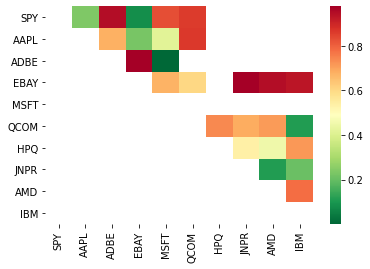

[('ADBE', 'MSFT')]


In [16]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

Les actions 'ADBE' and 'MSFT' sont cointégrées. Nous allons examiner leurs cours pour vérifier cela. 

0.0017888137740992515


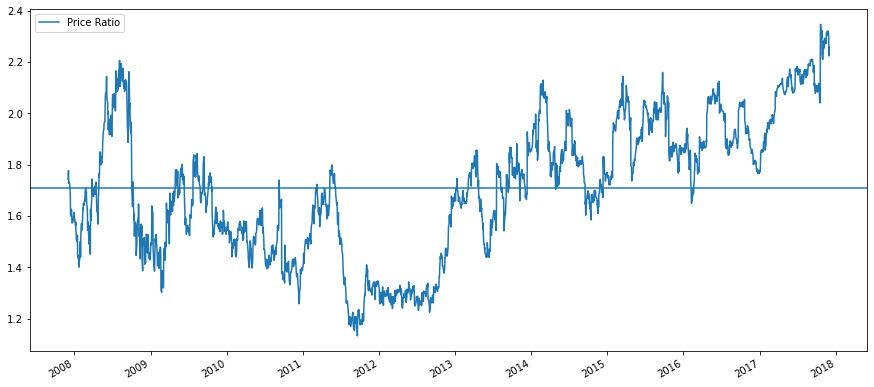

In [17]:
S1 = data['ADBE']
S2 = data['MSFT']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

Le rapport semble évoluer autour d'une moyenne stable. Le rapport absolu n'est pas très utile en termes statistiques. Il est plus utile de normaliser notre signal en le traitant comme un score Z. Le score Z est défini comme suit :

<i>Z Score Z (Valeur) = (Valeur — Moyenne) / Ecart-type </i>



In [18]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

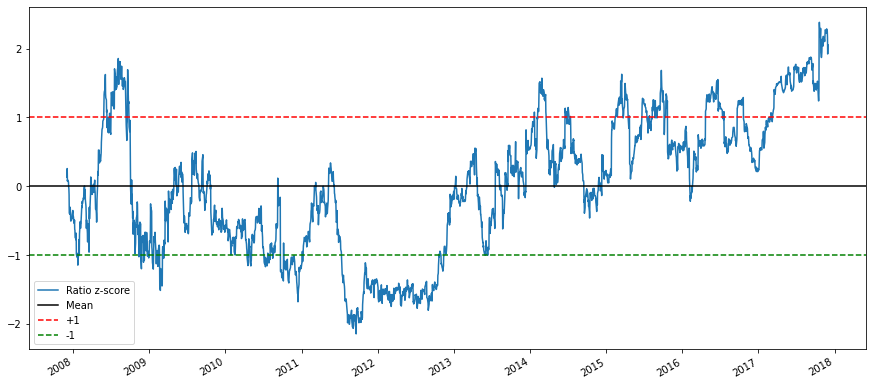

In [20]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

### Stratégie simple :
* Prendre une position longue sur le ratio lorsque le score Z est inférieur à -1.
* Vendre à découvert (ou prendre une position "short") sur le ratio lorsque le score Z est supérieur à 1.
* Liquider ses actions lorsque le score Z s'approche de zéro.

Il est recommandé d'utiliser des calculs statistiques qui reposent sur des fenêtres glissantes des données les plus récentes.

Au lieu d'utiliser des valeurs du ratio, utilisons la moyenne mobile sur 5jours pour calculer le score Z, et la moyenne mobile sur 60jours et l'écart type sur 60jours comme moyenne et écart type.

Divisons d'abord les données en un ensemble d'apprentissage de 7 ans et un ensemble de test de 3 ans.


In [21]:
ratios = data['ADBE'] / data['MSFT']
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

2518


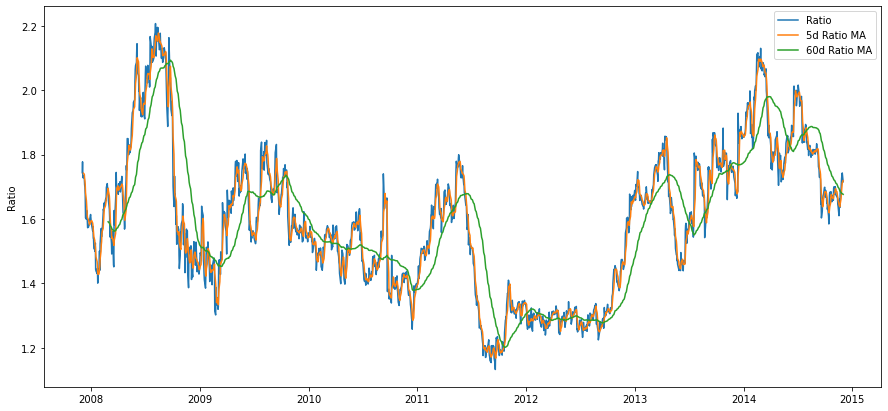

In [24]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

Nous pouvons utiliser les moyennes mobiles pour calculer le score Z du ratio à chaque moment. Cela nous indique à quel point le ratio est extrême et si c'est une bonne idée de prendre une position à ce moment-là. Regardons maintenant le score Z.


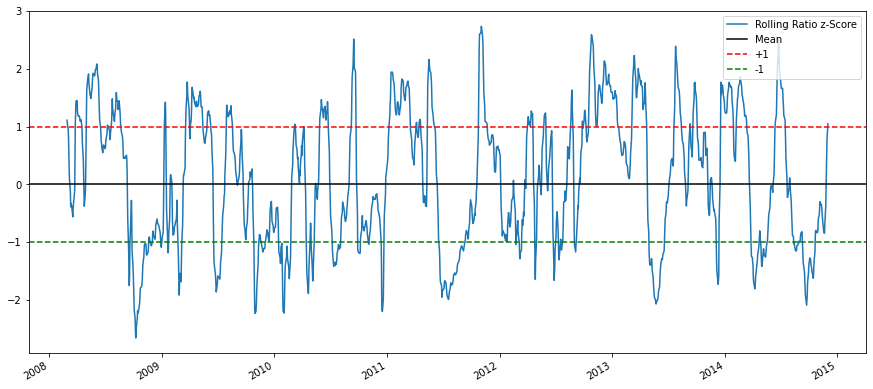

In [25]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

Le score Z tout seul ne nous apporte pas assez d'informations. On trace alors une graphique qui combine les informations fournies par le score Z, c'est-à-dire les signaux de ventes et d'achats ainsi que les informations relatives à l'évolution du prix (cours) de l'action dans le temps


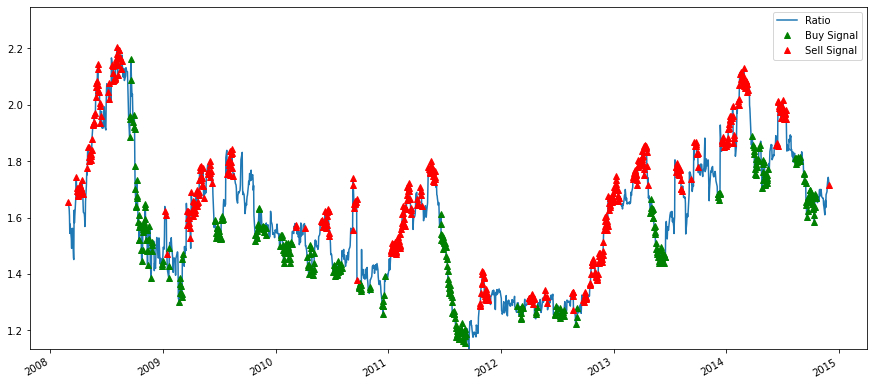

In [26]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

Que signifie donc cela pour les actions avec lesquelles on fait du trading ?
Lorsqu'on vend notre ratio, on vend l'action S1 et on achète l'action S2 et lorsqu'on achète notre ratio, on achète l'action S1 et on vend l'action S2. 

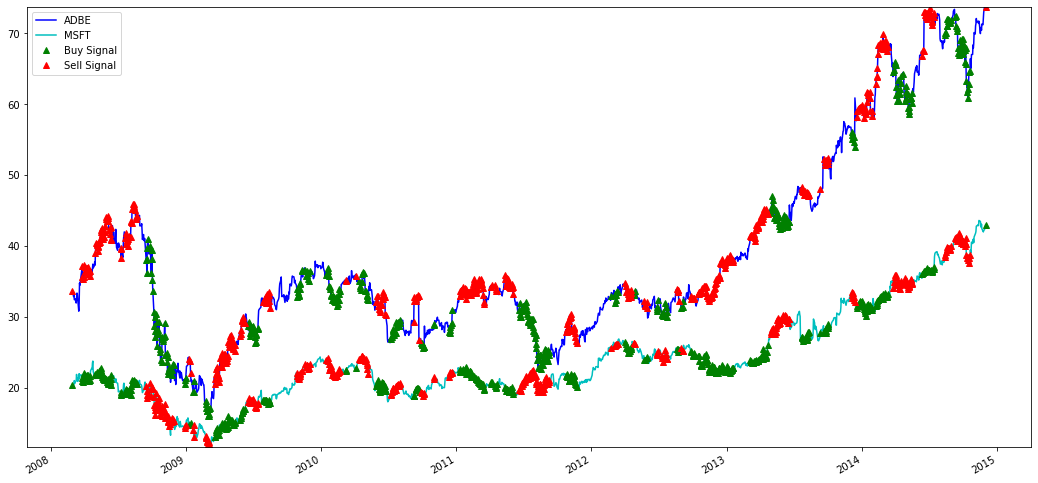

In [28]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['ADBE'].iloc[:1762]
S2 = data['MSFT'].iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()


Remarquons que nous gagnons parfois de l'argent sur le court terme, parfois sur le long terme, et parfois sur les deux.

Voyons quel type de profits ce signal peut générer. Nous écrivons un "backtester" simple pour évaluer notre stratégie qui achète 1 ratio (acheter 1 action ADBE et vendre ratio x action MSFT) quand le ratio est bas, vendre 1 ratio (vendre 1 action ADBE et acheter ratio x action MSFT) quand il est haut et calculer le PnL de ces trades (Profit and Loss Explained).

In [29]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762], 5, 60)


629.7081594652683

La stratégie semble ainsi rentable. Nous pouvons maintenant optimiser davantage en modifiant nos fenêtres de moyenne mobile, en changeant les seuils pour les positions d'achat/vente et de sortie, etc. et vérifier l'amélioration des performances sur les données de validation.

Voyons comment cela se passe sur les données de test.

In [30]:
trade(data['ADBE'].iloc[1762:], data['MSFT'].iloc[1762:], 5, 90)

1177.3686935739229

Nous réalisons aussi des profits sur nos données de tests !

### Ne pas tomber dans l'Overfitting

Dans notre modèle, nous avons utilisé des estimations de paramètres mais sans optimiser la longueur de la fenêtre. Nous pouvons simplement itérer sur toutes les longueurs de fenêtre possibles et raisonnables et choisir la longueur sur laquelle notre modèle est le plus performant. Ci-dessous, voici une boucle simple pour évaluer les longueurs de fenêtre en fonction de pnl de données afin de déterminer la plus adaptée, qui va générer le plus de gains.

In [33]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['ADBE'].iloc[:1762], 
                data['MSFT'].iloc[:1762], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 246


En vérifiant les performances du modèle en terme de gains sur les données de test on voit que l'on n'a pas choisi la longueur optimale, on était donc dans l'overfitting sur notre jeu de données.

In [34]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['ADBE'].iloc[1762:], 
                  data['MSFT'].iloc[1762:],5, l) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

246 day window: 987.0072656354919
191 day window: 1572.1957179762483


On observe également cela sur le notebook en traçant le PnL des données d'entraînement et de test 

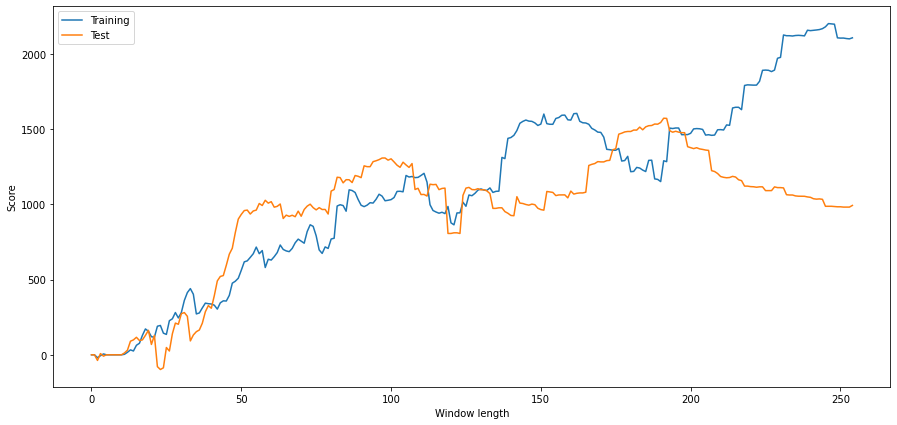

In [35]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4bb31aae-a2d0-4f74-a592-608df3e3aed0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>